In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_table('../附件/附件2：估价验证数据.txt', header=None)

columns = ['carId', 'tradeTime', 'brand', 'serial', 'model', 'mileage', 'color', 'cityId', 'carCode', 'tansferCount',
           'seatings', 'registerDate', 'licenseDate', 'country', 'makeType', 'modelYear', 'displacement', 'gearbox',
           'oilType', 'newPrice']
for i in range(15):
    columns.append('unknown' + str(i))
data.columns = columns
data

,carId,tradeTime,brand,serial,model,mileage,color,cityId,carCode,tansferCount,...,unknown5,unknown6,unknown7,unknown8,unknown9,unknown10,unknown11,unknown12,unknown13,unknown14
0,3,2021-09-26,3,3,3,6.64,2,3,1,0,...,1,NaN,2.0,5.0,2.0,1+2,4878*1925*1734,201710.0,1,NaN
1,4,2021-08-14,4,4,4,8.04,3,1,2,2,...,3,2018-06-14,1.0,3.0,2.0,1+2,3723*1683*1407,201010.0,2,NaN
2,8,2021-10-09,8,8,8,10.19,5,1,2,0,...,2,NaN,1.0,4.0,3.0,NaN,4415*1674*1415,201003.0,1,NaN
3,9,2021-09-30,9,9,9,2.27,2,2,4,0,...,1,NaN,2.0,5.0,NaN,1+2,4649*1830*1705,201907.0,2,NaN
4,11,2021-08-09,8,11,11,7.03,2,3,1,0,...,2,NaN,2.0,4.0,NaN,1+2,4933*1836*1469,201810.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,55510,2021-10-28,12,275,1023,8.53,1,1,1,1,...,6,2021-08-14,1.0,5.0,2.0,1+2,4845*1805*1695,201702.0,1,NaN
4996,1768,2021-08-23,17,480,1400,11.11,1,19,2,0,...,2,NaN,NaN,NaN,NaN,3+2,4740*1770*1480,201409.0,1,NaN
4997,20723,2021-09-03,7,166,1056,11.02,2,1,2,1,...,2,2015-10-14,1.0,4.0,3.0,1,4850*1795*1475,201011.0,1,NaN
4998,15625,2021-10-29,25,235,371,6.21,4,5,1,0,...,1,NaN,1.0,5.0,2.0,1,4100*1740*1635,201604.0,2,NaN


In [3]:
for col in ['tradeTime', 'registerDate', 'licenseDate']:
    data[col] = pd.to_datetime(data[col])
    del col

"""
@:param productionTime: 注册日期与展销日期的间隔
@:param useTime:    挂牌日期与展销时间的间隔
@:param time:   此款车型出的年限
将时间型数据转化为连续的数值型数据（年限）
"""
data.rename(columns={'registerDate': 'productionTime', 'licenseDate': 'useTime', 'modelYear': 'time'}, inplace=True)

data['productionTime'] = data['tradeTime'] - data['productionTime']
data['useTime'] = data['tradeTime'] - data['useTime']
data['time'] = 2021 - data['time']

data['productionTime'] = data['productionTime'].astype(np.str)
data['useTime'] = data['useTime'].astype(np.str)

data['productionTime'] = data['productionTime'].str.split()
data['productionTime'] = [np.float(i[0])/365 for i in data['productionTime'].tolist()]
data['useTime'] = data['useTime'].str.split()
data['useTime'] = [np.float(i[0])/365 for i in data['useTime'].tolist()]

<AxesSubplot:>

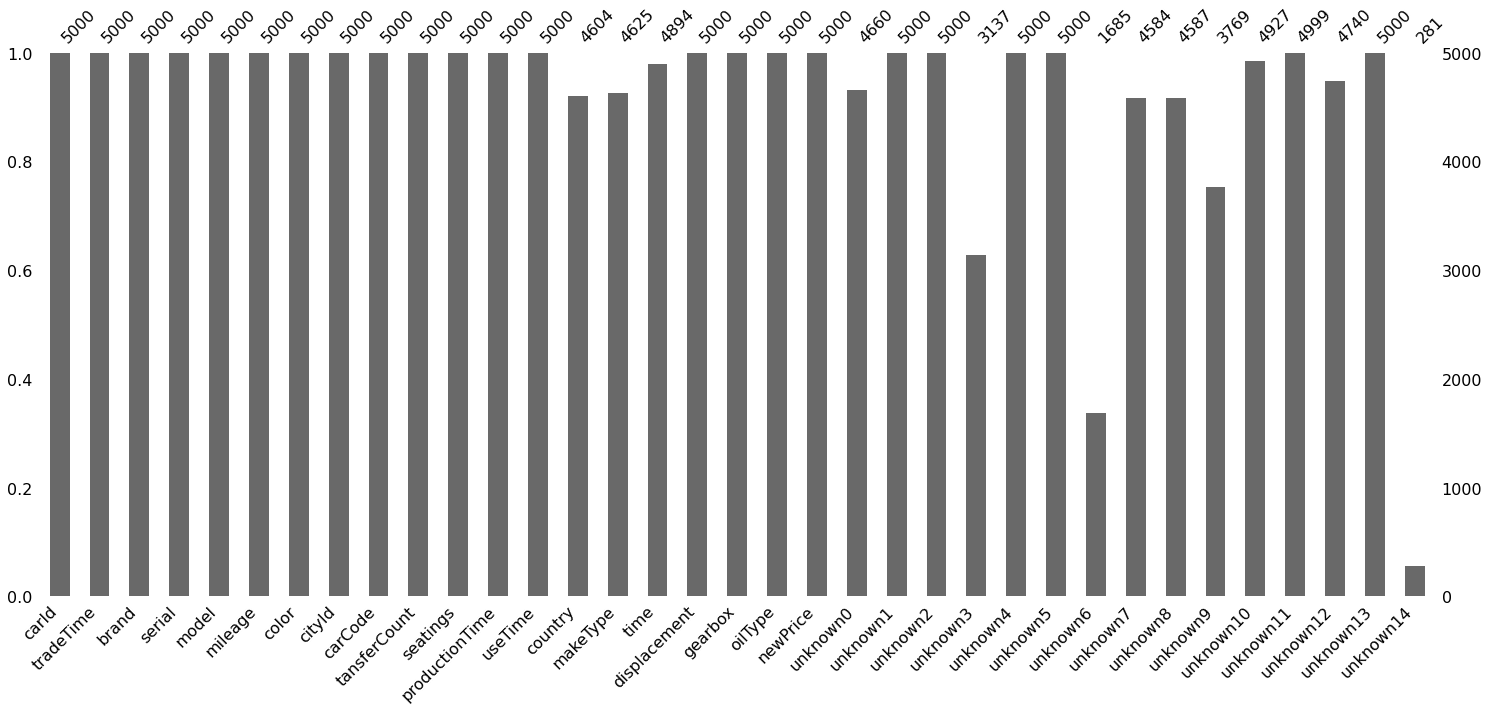

In [4]:
import missingno as mns

mns.bar(data)

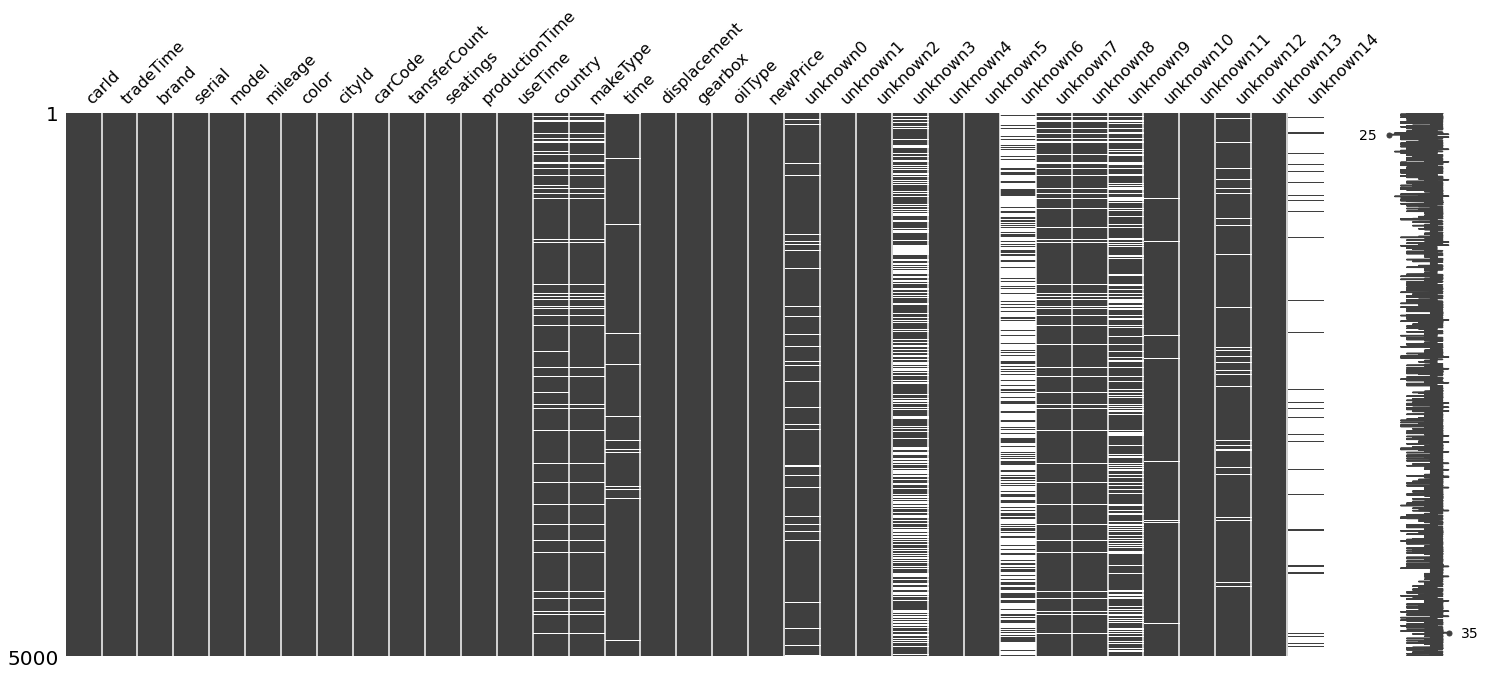

In [5]:
mns.matrix(data)
plt.savefig('./solve1/missing_matrix_test.png', dpi=800)

In [6]:
missing = (data.shape[0] - data.count()) / data.shape[0]
missing = missing[missing > 0.]
missing

country      0.0792
makeType     0.0750
time         0.0212
unknown0     0.0680
unknown3     0.3726
unknown6     0.6630
unknown7     0.0832
unknown8     0.0826
unknown9     0.2462
unknown10    0.0146
unknown11    0.0002
unknown12    0.0520
unknown14    0.9438
dtype: float64

In [7]:
data.drop(['unknown6', 'unknown14'], axis=1, inplace=True)
na = data[data['unknown11'].isna()]
data = data[data['unknown11'].notna()]
missing = missing[missing > .03]
missing = missing[missing < .6]
missing

country      0.0792
makeType     0.0750
unknown0     0.0680
unknown3     0.3726
unknown7     0.0832
unknown8     0.0826
unknown9     0.2462
unknown12    0.0520
dtype: float64

In [8]:
data

,carId,tradeTime,brand,serial,model,mileage,color,cityId,carCode,tansferCount,...,unknown3,unknown4,unknown5,unknown7,unknown8,unknown9,unknown10,unknown11,unknown12,unknown13
0,3,2021-09-26,3,3,3,6.64,2,3,1,0,...,3.0,3,1,2.0,5.0,2.0,1+2,4878*1925*1734,201710.0,1
1,4,2021-08-14,4,4,4,8.04,3,1,2,2,...,4.0,4,3,1.0,3.0,2.0,1+2,3723*1683*1407,201010.0,2
2,8,2021-10-09,8,8,8,10.19,5,1,2,0,...,NaN,8,2,1.0,4.0,3.0,NaN,4415*1674*1415,201003.0,1
3,9,2021-09-30,9,9,9,2.27,2,2,4,0,...,9.0,9,1,2.0,5.0,NaN,1+2,4649*1830*1705,201907.0,2
4,11,2021-08-09,8,11,11,7.03,2,3,1,0,...,11.0,10,2,2.0,4.0,NaN,1+2,4933*1836*1469,201810.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,55510,2021-10-28,12,275,1023,8.53,1,1,1,1,...,204.0,16,6,1.0,5.0,2.0,1+2,4845*1805*1695,201702.0,1
4996,1768,2021-08-23,17,480,1400,11.11,1,19,2,0,...,19.0,19,2,NaN,NaN,NaN,3+2,4740*1770*1480,201409.0,1
4997,20723,2021-09-03,7,166,1056,11.02,2,1,2,1,...,168.0,7,2,1.0,4.0,3.0,1,4850*1795*1475,201011.0,1
4998,15625,2021-10-29,25,235,371,6.21,4,5,1,0,...,182.0,28,1,1.0,5.0,2.0,1,4100*1740*1635,201604.0,2


In [9]:
# data['unknown11'].fillna('nan * nan * nan', inplace=True)
data['unknown11'] = data['unknown11'].str.split('*')
data['unknown11_1'] = [np.float(i[0])/1000 for i in data['unknown11'].tolist()]
data['unknown11_2'] = [np.float(i[1])/1000 for i in data['unknown11'].tolist()]
data['unknown11_3'] = [np.float(i[2])/1000 for i in data['unknown11'].tolist()]
data.drop(columns=['unknown11'], inplace=True)

_ = data[data['unknown12'].notna()]
_['unknown12'] = pd.to_datetime(_['unknown12'], format='%Y%m')
_['unknown12'] = _['tradeTime'] - _['unknown12']
_['unknown12'] = _['unknown12'].astype(np.str)
_['unknown12'] = _['unknown12'].str.split()
_['unknown12'] = [np.float(i[0])/365 for i in _['unknown12'].tolist()]
data.loc[data['unknown12'].notna(), 'unknown12'] = _['unknown12']

data

,carId,tradeTime,brand,serial,model,mileage,color,cityId,carCode,tansferCount,...,unknown5,unknown7,unknown8,unknown9,unknown10,unknown12,unknown13,unknown11_1,unknown11_2,unknown11_3
0,3,2021-09-26,3,3,3,6.64,2,3,1,0,...,1,2.0,5.0,2.0,1+2,3.989041,1,4.878,1.925,1.734
1,4,2021-08-14,4,4,4,8.04,3,1,2,2,...,3,1.0,3.0,2.0,1+2,10.876712,2,3.723,1.683,1.407
2,8,2021-10-09,8,8,8,10.19,5,1,2,0,...,2,1.0,4.0,3.0,NaN,11.616438,1,4.415,1.674,1.415
3,9,2021-09-30,9,9,9,2.27,2,2,4,0,...,1,2.0,5.0,NaN,1+2,2.252055,2,4.649,1.830,1.705
4,11,2021-08-09,8,11,11,7.03,2,3,1,0,...,2,2.0,4.0,NaN,1+2,2.857534,1,4.933,1.836,1.469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,55510,2021-10-28,12,275,1023,8.53,1,1,1,1,...,6,1.0,5.0,2.0,1+2,4.739726,1,4.845,1.805,1.695
4996,1768,2021-08-23,17,480,1400,11.11,1,19,2,0,...,2,NaN,NaN,NaN,3+2,6.980822,1,4.740,1.770,1.480
4997,20723,2021-09-03,7,166,1056,11.02,2,1,2,1,...,2,1.0,4.0,3.0,1,10.846575,1,4.850,1.795,1.475
4998,15625,2021-10-29,25,235,371,6.21,4,5,1,0,...,1,1.0,5.0,2.0,1,5.580822,2,4.100,1.740,1.635


In [10]:
data

,carId,tradeTime,brand,serial,model,mileage,color,cityId,carCode,tansferCount,...,unknown5,unknown7,unknown8,unknown9,unknown10,unknown12,unknown13,unknown11_1,unknown11_2,unknown11_3
0,3,2021-09-26,3,3,3,6.64,2,3,1,0,...,1,2.0,5.0,2.0,1+2,3.989041,1,4.878,1.925,1.734
1,4,2021-08-14,4,4,4,8.04,3,1,2,2,...,3,1.0,3.0,2.0,1+2,10.876712,2,3.723,1.683,1.407
2,8,2021-10-09,8,8,8,10.19,5,1,2,0,...,2,1.0,4.0,3.0,NaN,11.616438,1,4.415,1.674,1.415
3,9,2021-09-30,9,9,9,2.27,2,2,4,0,...,1,2.0,5.0,NaN,1+2,2.252055,2,4.649,1.830,1.705
4,11,2021-08-09,8,11,11,7.03,2,3,1,0,...,2,2.0,4.0,NaN,1+2,2.857534,1,4.933,1.836,1.469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,55510,2021-10-28,12,275,1023,8.53,1,1,1,1,...,6,1.0,5.0,2.0,1+2,4.739726,1,4.845,1.805,1.695
4996,1768,2021-08-23,17,480,1400,11.11,1,19,2,0,...,2,NaN,NaN,NaN,3+2,6.980822,1,4.740,1.770,1.480
4997,20723,2021-09-03,7,166,1056,11.02,2,1,2,1,...,2,1.0,4.0,3.0,1,10.846575,1,4.850,1.795,1.475
4998,15625,2021-10-29,25,235,371,6.21,4,5,1,0,...,1,1.0,5.0,2.0,1,5.580822,2,4.100,1.740,1.635


In [11]:
data['tradeTime'] = pd.to_datetime('2021-12-31') - data['tradeTime']
data['tradeTime'] = data['tradeTime'].astype(np.str)
data['tradeTime'] = data['tradeTime'].str.split()
data['tradeTime'] = [np.float(i[0])/365 for i in data['tradeTime'].tolist()]

data

,carId,tradeTime,brand,serial,model,mileage,color,cityId,carCode,tansferCount,...,unknown5,unknown7,unknown8,unknown9,unknown10,unknown12,unknown13,unknown11_1,unknown11_2,unknown11_3
0,3,0.263014,3,3,3,6.64,2,3,1,0,...,1,2.0,5.0,2.0,1+2,3.989041,1,4.878,1.925,1.734
1,4,0.380822,4,4,4,8.04,3,1,2,2,...,3,1.0,3.0,2.0,1+2,10.876712,2,3.723,1.683,1.407
2,8,0.227397,8,8,8,10.19,5,1,2,0,...,2,1.0,4.0,3.0,NaN,11.616438,1,4.415,1.674,1.415
3,9,0.252055,9,9,9,2.27,2,2,4,0,...,1,2.0,5.0,NaN,1+2,2.252055,2,4.649,1.830,1.705
4,11,0.394521,8,11,11,7.03,2,3,1,0,...,2,2.0,4.0,NaN,1+2,2.857534,1,4.933,1.836,1.469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,55510,0.175342,12,275,1023,8.53,1,1,1,1,...,6,1.0,5.0,2.0,1+2,4.739726,1,4.845,1.805,1.695
4996,1768,0.356164,17,480,1400,11.11,1,19,2,0,...,2,NaN,NaN,NaN,3+2,6.980822,1,4.740,1.770,1.480
4997,20723,0.326027,7,166,1056,11.02,2,1,2,1,...,2,1.0,4.0,3.0,1,10.846575,1,4.850,1.795,1.475
4998,15625,0.172603,25,235,371,6.21,4,5,1,0,...,1,1.0,5.0,2.0,1,5.580822,2,4.100,1.740,1.635


In [12]:
from sklearn.metrics import f1_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from pickle import load

# data = pd.get_dummies(data, columns=['unknown10'])
feature = [i for i in data.columns if i not in missing.index and i not in ['price']]
acc = pd.DataFrame(index=missing.index, columns=['accuracy', 'score'])

missing = missing.reindex(index=['unknown0', 'country', 'unknown8', 'makeType', 'unknown9', 'unknown7', 'unknown12', 'time', 'unknown3'])
score = []
f1 = []

data['unknown10'] = LabelEncoder().fit_transform(data['unknown10'])

with open('./dict.pk', 'rb') as f:
    cols = load(f)
    _ = cols[:6]
    _.extend(cols[7: -1])
    cols = _

for col, column in zip(missing.index, cols):
    dt = DecisionTreeClassifier(random_state=42)
    if col in ['time', 'unknown12']:
        dt = DecisionTreeRegressor(random_state=42)
    PATH = "../models/" + str(col) + "-" + str(dt) + '.pk'
    with open(PATH, 'rb') as f:
        model = load(f)
    nan = data[data[col].isna()]
    X_ = nan[column]
    print(PATH)
    y_pre = model.predict(X_)
    data.loc[data[col].isnull(), col] = y_pre

data.isna().any()

../models/unknown0-DecisionTreeClassifier(random_state=42).pk
../models/country-DecisionTreeClassifier(random_state=42).pk
../models/unknown8-DecisionTreeClassifier(random_state=42).pk
../models/makeType-DecisionTreeClassifier(random_state=42).pk
../models/unknown9-DecisionTreeClassifier(random_state=42).pk
../models/unknown7-DecisionTreeClassifier(random_state=42).pk
../models/unknown12-DecisionTreeRegressor(random_state=42).pk
../models/time-DecisionTreeRegressor(random_state=42).pk


carId             False
tradeTime         False
brand             False
serial            False
model             False
mileage           False
color             False
cityId            False
carCode           False
tansferCount      False
seatings          False
productionTime    False
useTime           False
country           False
makeType          False
time              False
displacement      False
gearbox           False
oilType           False
newPrice          False
unknown0          False
unknown1          False
unknown2          False
unknown3           True
unknown4          False
unknown5          False
unknown7          False
unknown8          False
unknown9          False
unknown10         False
unknown12         False
unknown13         False
unknown11_1       False
unknown11_2       False
unknown11_3       False
dtype: bool

In [13]:
data['country'].value_counts()

779412.0    1801
779415.0    1043
779413.0     758
779416.0     735
779419.0     204
779411.0     155
779414.0     149
779418.0      76
779421.0      44
0.0           19
779417.0      15
Name: country, dtype: int64

In [14]:
data['country'].replace(0, 779413, inplace=True)
data

,carId,tradeTime,brand,serial,model,mileage,color,cityId,carCode,tansferCount,...,unknown5,unknown7,unknown8,unknown9,unknown10,unknown12,unknown13,unknown11_1,unknown11_2,unknown11_3
0,3,0.263014,3,3,3,6.64,2,3,1,0,...,1,2.0,5.0,2.0,1,3.989041,1,4.878,1.925,1.734
1,4,0.380822,4,4,4,8.04,3,1,2,2,...,3,1.0,3.0,2.0,1,10.876712,2,3.723,1.683,1.407
2,8,0.227397,8,8,8,10.19,5,1,2,0,...,2,1.0,4.0,3.0,4,11.616438,1,4.415,1.674,1.415
3,9,0.252055,9,9,9,2.27,2,2,4,0,...,1,2.0,5.0,2.0,1,2.252055,2,4.649,1.830,1.705
4,11,0.394521,8,11,11,7.03,2,3,1,0,...,2,2.0,4.0,3.0,1,2.857534,1,4.933,1.836,1.469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,55510,0.175342,12,275,1023,8.53,1,1,1,1,...,6,1.0,5.0,2.0,1,4.739726,1,4.845,1.805,1.695
4996,1768,0.356164,17,480,1400,11.11,1,19,2,0,...,2,1.0,4.0,3.0,3,6.980822,1,4.740,1.770,1.480
4997,20723,0.326027,7,166,1056,11.02,2,1,2,1,...,2,1.0,4.0,3.0,0,10.846575,1,4.850,1.795,1.475
4998,15625,0.172603,25,235,371,6.21,4,5,1,0,...,1,1.0,5.0,2.0,0,5.580822,2,4.100,1.740,1.635


In [15]:
carId = data['carId']

In [16]:
all = pd.read_csv('./all.csv', index_col=1)
all = pd.concat([all, data], axis=0, ignore_index=True)
all.to_csv('./all.csv', index=False)
classif = ['cityId', 'brand', 'serial', 'model', 'gearbox', 'displacement', 'unknown1', 'unknown3', 'unknown4',
            'color', 'tansferCount', 'makeType', 'unknown5', 'unknown7', 'unknown8',
            'unknown9', 'unknown13', 'seatings', 'country']

# from sklearn.preprocessing import MinMaxScaler
with open('./encoder_2.pk', 'rb') as f:
    encoder = load(f)
data[classif] = encoder.transform(data[classif])

with open('./encoder.ok', 'rb') as f:
    encoder_un10 = load(f)
data['unknown10'] = encoder_un10.transform(data['unknown10'])
data.to_csv('./data2.csv')
data.drop(['carId', 'oilType', 'unknown0', 'unknown2'], axis=1, inplace=True)
data.drop(['productionTime', 'unknown12', 'useTime', 'carCode'], axis=1, inplace=True)

In [17]:
with open('../models/xgboost.pk', 'rb') as f:
    model = load(f)

price = model.predict(data)
price

array([2.8141205, 2.1811805, 1.0569804, ..., 1.6765077, 1.2775862,
       2.608056 ], dtype=float32)

In [18]:
data

,tradeTime,brand,serial,model,mileage,color,cityId,tansferCount,seatings,country,...,unknown4,unknown5,unknown7,unknown8,unknown9,unknown10,unknown13,unknown11_1,unknown11_2,unknown11_3
0,0.263014,8.966354,17.239998,14.347985,6.64,19.351054,13.583153,13.657052,18.678786,10.903341,...,6.965966,16.808603,16.675436,14.743833,14.945621,18.06524,14.621999,4.878,1.925,1.734
1,0.380822,14.195162,14.235786,9.380000,8.04,16.314734,17.388693,15.137601,25.898959,30.050507,...,14.136791,7.444239,9.613303,11.545118,14.945621,18.06524,13.927286,3.723,1.683,1.407
2,0.227397,10.079492,4.859772,2.670734,10.19,10.654346,17.388693,13.657052,13.250811,19.340521,...,9.274063,13.283662,9.613303,13.333862,13.748810,18.06524,14.621999,4.415,1.674,1.415
3,0.252055,7.130208,6.536006,8.599682,2.27,19.351054,8.711682,13.657052,13.250811,6.317522,...,7.681486,16.808603,16.675436,14.743833,14.945621,18.06524,13.927286,4.649,1.830,1.705
4,0.394521,10.079492,12.429634,16.688846,7.03,19.351054,13.583153,13.657052,13.250811,19.340521,...,9.554792,13.283662,16.675436,13.333862,13.748810,18.06524,14.621999,4.933,1.836,1.469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.175342,11.399387,16.086387,21.682940,8.53,13.676086,17.388693,15.319610,18.678786,12.598153,...,11.134994,16.011837,9.613303,14.743833,14.945621,18.06524,14.621999,4.845,1.805,1.695
4996,0.356164,6.469184,5.705116,4.946253,11.11,13.676086,11.967044,13.657052,13.250811,6.317522,...,6.469184,13.283662,9.613303,13.333862,13.748810,18.06524,14.621999,4.740,1.770,1.480
4997,0.326027,9.433572,10.001093,7.522614,11.02,19.351054,17.388693,15.319610,13.250811,12.598153,...,8.412363,13.283662,9.613303,13.333862,13.748810,18.06524,14.621999,4.850,1.795,1.475
4998,0.172603,4.947638,4.117876,14.347985,6.21,10.811612,8.155523,13.657052,13.250811,6.317522,...,4.907359,16.808603,9.613303,14.743833,14.945621,18.06524,13.927286,4.100,1.740,1.635


In [19]:
def true(log1p):
    return np.e ** log1p - 1

price = true(price)
price

array([15.678499 ,  7.8567543,  1.8776684, ...,  4.3468504,  2.5879686,
       12.572639 ], dtype=float32)

In [20]:
result = pd.DataFrame(columns=['车辆id', '预测价格'])
result['车辆id'] = carId
result['预测价格'] = price.round(2)
result

,车辆id,预测价格
0,3,15.68
1,4,7.86
2,8,1.88
3,9,6.00
4,11,15.87
...,...,...
4995,55510,20.68
4996,1768,4.42
4997,20723,4.35
4998,15625,2.59


In [21]:
result.to_csv('../附件/附件3：估价模型结果.txt', index=False, header=False, sep='\t')

In [22]:
error = pd.read_csv('./catboost_info/learn_error.tsv', sep='\t', index_col=0)
t_error = pd.read_csv('./catboost_info/test_error.tsv', sep='\t', index_col=0)
error

,RMSE
iter,
0,0.676552
1,0.628704
2,0.586282
3,0.546759
4,0.511197
...,...
995,0.101393
996,0.101392
997,0.101392


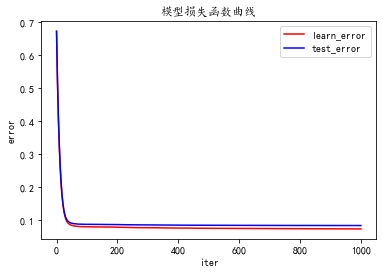

In [47]:
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.plot(error, 'r', label='learn_error')
plt.plot(t_error, 'b', label='test_error')
plt.xlabel('iter')
plt.ylabel('error')
plt.title('模型损失函数曲线')
plt.legend()
plt.savefig('./solve1/catboost.png', dpi=800)

In [48]:
all.isna().any()

Unnamed: 0         True
tradeTime         False
brand             False
serial            False
model             False
mileage           False
color             False
cityId            False
carCode           False
tansferCount      False
seatings          False
productionTime    False
useTime           False
country           False
makeType          False
time              False
displacement      False
gearbox           False
oilType           False
newPrice          False
unknown0          False
unknown1          False
unknown2          False
unknown3           True
unknown4          False
unknown5          False
unknown7          False
unknown8          False
unknown9          False
unknown10         False
unknown12         False
unknown13         False
price              True
unknown11_1       False
unknown11_2       False
unknown11_3       False
carId              True
dtype: bool